# Denoising Autoencoders (DAE)

Hi and welcome! This time you will clean noisy documents images using autoencoders. You will create you own encoder and decoder nets and train them to denoise images.

Let's get started!

**GPU** is recomended for this assignment. `Runtime` -> `Change runtime type` -> `GPU`

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to define custom dataset with the same random transformations
- How to build autoencoders algorithm:
    - How to build a custom encoder
    - How to build a custom decoder
    - How to use pretrained network as an encoder
    - How to train and evaluate image autoencoders

# 0 - Download the data

In [1]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/5_autoencoder/denoising_autoencoder/template.zip')
!unzip -q template.zip

# 1 - Import packages

In [28]:
import torch
import torchvision

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from torch import optim

from tqdm import tqdm
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image

%matplotlib inline

## Config

In [29]:
# VALIDATION_FIELD[cls] Config

class Config:
    # training
    seed = 21
    num_epochs=20
    lr=0.0005
    batch_size=8
    clip_value=1
    logdir = 'logdir'
    
    # data 
    data_dir='dirty_documents'
    eval_size=0.2
    stack_ratio=0.5
    transformed_size=(400, 400)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [30]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# 2 - Data preprocessing

We will be using the dataset of dirty documents images from [Kaggle](https://www.kaggle.com/c/denoising-dirty-documents/data).

The downloaded dataset has this structure:

- `train` - contains 144 noisy (crumpled, scratched, or dirty) images of documents. The text on the pictures is pretty much the same, but each image has a different font and noise. The name of the single image is `[number_of_image].jpg`
- `train_cleaned` - contains the same 144 images of documents, but without any noise. The name of the single image is also `number_of_image.jpg`, corresponding to the noisy images from `train`
-`test` - contains 72 noisy(crumpled, scratched, dirty) images of documents. Text on the pictures is different from `train` but is the same in all `test` images. The name of the single image is `number_of_image.jpg`

It's useful to note that the size of pictures may vary.

Most of the pictures in `train`, `train_cleaned` and `test` dataset is `(540, 420)`, but about 30% is `(540, 258)`

In [31]:
noisy_folder_path = os.path.join(Config.data_dir, 'train')
clean_folder_path = os.path.join(Config.data_dir, 'train_cleaned')
eval_folder_path = os.path.join(Config.data_dir, 'test')

images_names = os.listdir(noisy_folder_path)
eval_names = os.listdir(eval_folder_path)

images_names.sort()
eval_names.sort()

## Visualize Examples

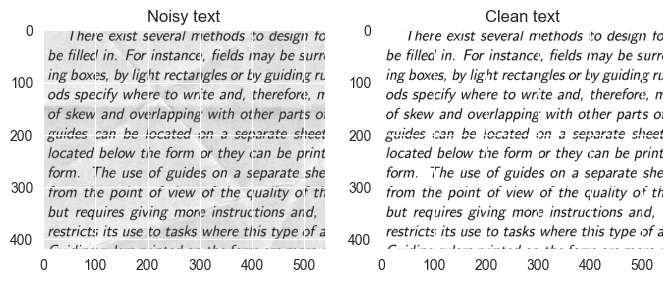

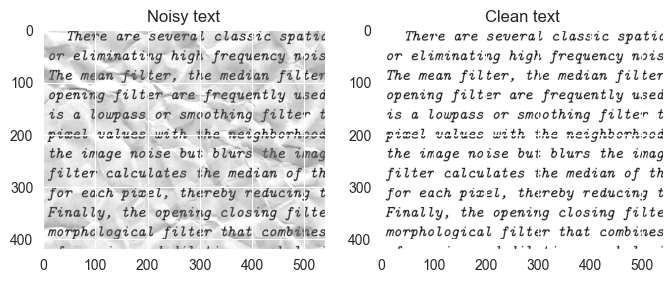

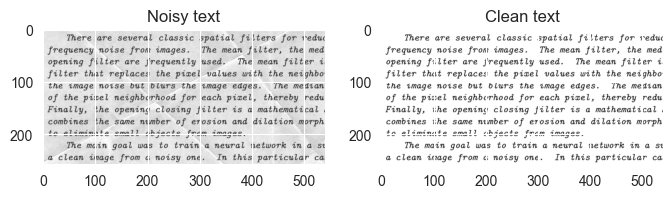

In [32]:
def plot_example(idx):
    noisy_path = os.path.join(noisy_folder_path, images_names[idx])
    clean_path = os.path.join(clean_folder_path, images_names[idx])
    noisy = Image.open(noisy_path)
    clean = Image.open(clean_path)
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(noisy, cmap='gray')
    ax[0].set_title('Noisy text')
    ax[1].imshow(clean, cmap='gray') 
    ax[1].set_title('Clean text')
    plt.show()

plot_example(0)
plot_example(23)
plot_example(110)

# Dimensions

As you can see from the examples above, our images have different hieghts. So, let's visualize the heights of the images in the dataset

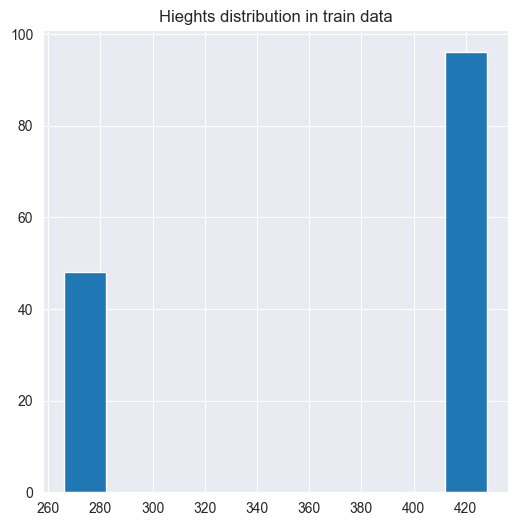

In [33]:
heights = [] 
for img in images_names:
    path = os.path.join(clean_folder_path, img)
    w, h = Image.open(path).size
    heights.append(h)
plt.figure(figsize = (6, 6))
plt.hist(heights, align='right')
plt.title('Hieghts distribution in train data')
plt.show()

As you can see from the histogram above, there are ≈50 images that have a much smaller height than the rest. Let's build a custom transform that fixes this problem. 

## Transforms

Similar to the UNet problem, here, we have to deal with a **paired** dataset and apply the same random transforms on both the clean and noisy image to preserve the dataset's structure.

Further in the Lab we will use the following transformations:
1. `PairedToTensor()` - transforms `noisy` and `clean` images to `torch.Tensor`
2. `PairedStack(stack_ratio)` - In case of image's height/width ratio is lower then given `stack_ratio`, stacks vertically image with itself (applied to both images at once)
3. `PairedRandomCrop(size)` - Apply **the same** random crop with given `size` to noisy and clean image at once
4. `PairedCenterCrop(size)` - Applies center crop with given `size` to noisy and clean image at once

**Exercise:**
1. Complete `class PairedToTensor`
2. Complete `class PairedStack`
3. Complete `class PairedRandomCrop`
4. Complete `class PairedCenterCrop`

In [34]:
# Function to draw first elements of the batch
def show_tensor_batch(batch, title=None):
    fig, ax = plt.subplots(1, 2, figsize = (10, 10))
    if title:
        fig.suptitle(title, y=0.7)
    ax[0].imshow(batch[0][0], cmap='gray')
    ax[1].imshow(batch[1][0], cmap='gray')
    
    plt.show()

In [35]:
# VALIDATION_FIELD[cls] PairedToTensor

class PairedToTensor:
    def __call__(self, batch):
        noisy, clean = batch 
        ### START CODE HERE ### (≈ 2 lines of code)
        noisy = transforms.ToTensor()(noisy)
        clean = transforms.ToTensor()(clean)
        ### END CODE HERE ###
        return noisy, clean

In [36]:
noisy_path = os.path.join(noisy_folder_path, images_names[0])
clean_path = os.path.join(clean_folder_path, images_names[0])
noisy = Image.open(noisy_path)
clean = Image.open(clean_path)
batch = noisy, clean

ToTensor = PairedToTensor()
print(f'Type of noisy image: {ToTensor(batch)[0].type()}', \
      f'\nType of clean image: {ToTensor(batch)[1].type()}')

Type of noisy image: torch.FloatTensor 
Type of clean image: torch.FloatTensor


**Expected output:**
    
<table>
    <tr>
        <td><b>Type of noisy image:</b></td>
        <td>torch.FloatTensor
        </td>
    </tr>
    <tr>
        <td><b>Type of clean image:</b></td>
        <td>torch.FloatTensor
        </td>
    </tr>

</table>

In [37]:
# VALIDATION_FIELD[cls] PairedStack

class PairedStack:
    def __init__(self, stack_ratio):
        self.stack_ratio = stack_ratio
    
    def __call__(self, batch):
        noisy, clean = batch
        ### START CODE HERE ### (≈ 3-6 lines of code)
        heigth, width = noisy.shape[1], noisy.shape[2]
        if heigth/width < self.stack_ratio:
            noisy = torch.cat([noisy, noisy], dim=1)
            clean = torch.cat([clean, clean], dim=1)
            
        ### END CODE HERE ###
        return noisy, clean

Shape of noisy and clean images in first batch: torch.Size([1, 420, 540]), torch.Size([1, 420, 540])
Shape of noisy and clean images in second batch: torch.Size([1, 516, 540]), torch.Size([1, 516, 540])


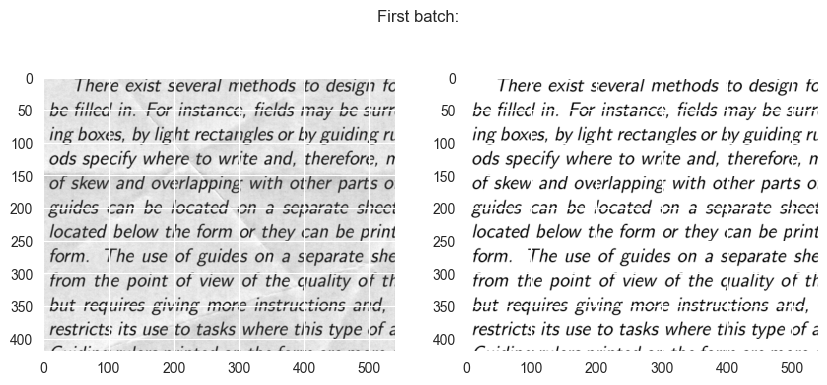

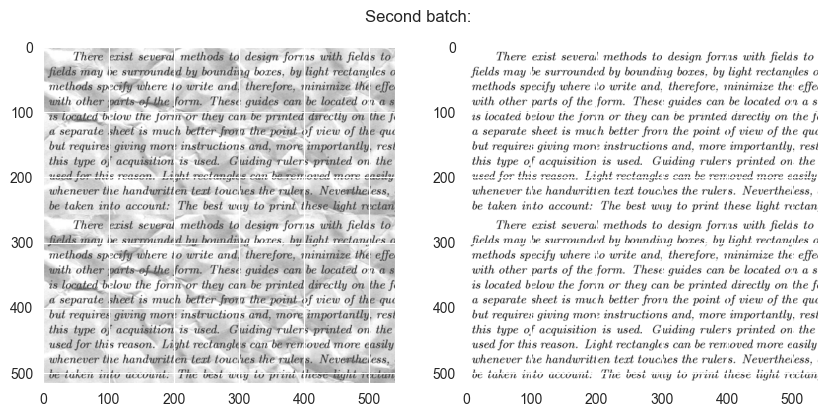

In [38]:
# test PairedStack

noisy_path_1 = os.path.join(noisy_folder_path, images_names[0])
clean_path_1 = os.path.join(clean_folder_path, images_names[0])
noisy_1 = Image.open(noisy_path_1)
clean_1 = Image.open(clean_path_1)
batch_1 = noisy_1, clean_1

noisy_path_2 = os.path.join(noisy_folder_path, images_names[6])
clean_path_2 = os.path.join(clean_folder_path, images_names[6])
noisy_2 = Image.open(noisy_path_2)
clean_2 = Image.open(clean_path_2)
batch_2 = noisy_2, clean_2

ToTensor = PairedToTensor()
batch_1 = ToTensor(batch_1)
batch_2 = ToTensor(batch_2)

Stack = PairedStack(Config.stack_ratio)
batch_1 = Stack(batch_1)
batch_2 = Stack(batch_2)

print(f'Shape of noisy and clean images in first batch: {batch_1[0].shape}, {batch_1[1].shape}')
print(f'Shape of noisy and clean images in second batch: {batch_2[0].shape}, {batch_2[1].shape}')

show_tensor_batch(batch_1, title="First batch:")
show_tensor_batch(batch_2, title="Second batch:")

**Expected output:**
    
<table>
    <tr>
        <td><b>Shapes of images in the first batch:</b></td>
        <td>torch.Size([1, 420, 540]), torch.Size([1, 420, 540])
        </td>
    </tr>
    <tr>
        <td><b>Shapes of images in the second batch:</b></td>
        <td>torch.Size([1, 516, 540]) torch.Size([1, 516, 540])
        </td>
    </tr>

</table>

*Noisy and clean images of second batch must look like 2 initial noisy and clean `258x540` images stacked on top of themselves, forming 2 new `516x540` images*

In [39]:
# VALIDATION_FIELD[cls] PairedRandomCrop

class PairedRandomCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, batch):
        noisy, clean = batch
        ### START CODE HERE ### (≈ 3-6 lines of code)
        i, j, h, w = transforms.RandomCrop.get_params(noisy, output_size=self.size)
        noisy = transforms.functional.crop(noisy, i, j, h, w)
        clean = transforms.functional.crop(clean, i, j, h, w)
        ### END CODE HERE ###
        return noisy, clean

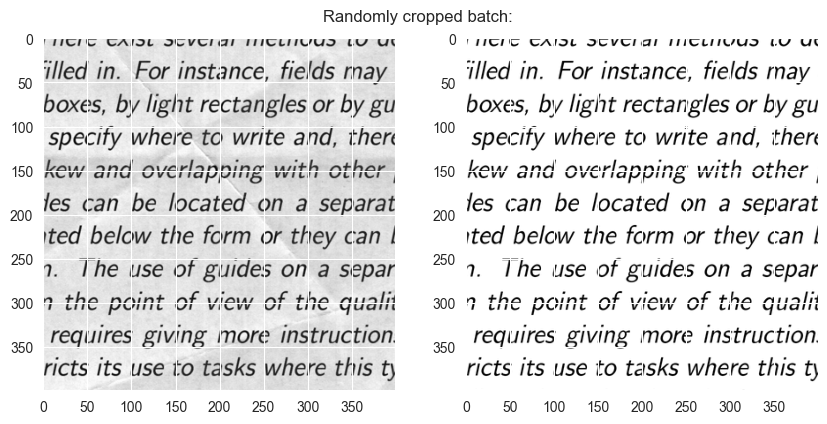

In [40]:
noisy_path = os.path.join(noisy_folder_path, images_names[0])
clean_path = os.path.join(clean_folder_path, images_names[0])
noisy = Image.open(noisy_path)
clean = Image.open(clean_path)
batch = noisy, clean

ToTensor = PairedToTensor()
batch = ToTensor(batch)

Stack = PairedStack(Config.stack_ratio)
batch = Stack(batch)

Crop = PairedRandomCrop(Config.transformed_size)
batch = Crop(batch)

show_tensor_batch(batch, title="Randomly cropped batch:")

**Expected output:** *Images must depict same area of a document*

In [41]:
# VALIDATION_FIELD[cls] PairedCenterCrop

class PairedCenterCrop:
    def __init__(self, size):
        self.size = size

    def __call__(self, batch):
        noisy, clean = batch
        ### START CODE HERE ### (≈ 2 lines of code)
        noisy = transforms.functional.center_crop(noisy, self.size)
        clean = transforms.functional.center_crop(clean, self.size)
        ### END CODE HERE ###
        return noisy, clean

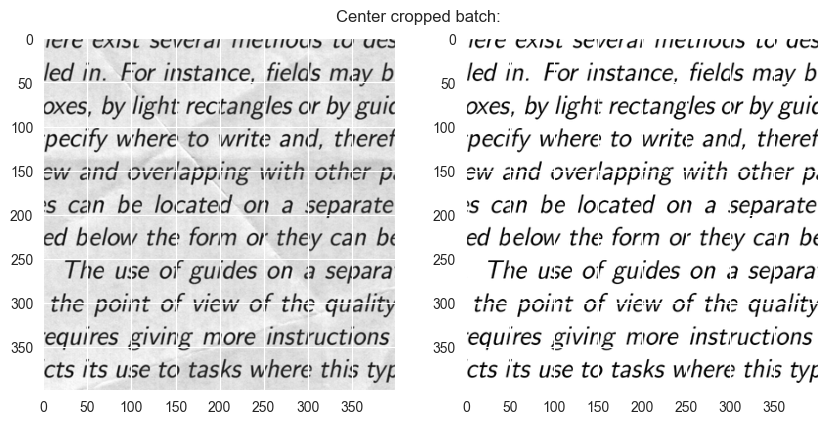

In [42]:
noisy_path = os.path.join(noisy_folder_path, images_names[0])
clean_path = os.path.join(clean_folder_path, images_names[0])
noisy = Image.open(noisy_path)
clean = Image.open(clean_path)
batch = noisy, clean

ToTensor = PairedToTensor()
batch = ToTensor(batch)

Stack = PairedStack(Config.stack_ratio)
batch = Stack(batch)

Crop = PairedCenterCrop(Config.transformed_size)
batch = Crop(batch)

show_tensor_batch(batch, title="Center cropped batch:")

**Expected output:** *Images must depict center area of a document*

### Putting all together

Now we'll `Compose` transformations for train and eval datasets

**For train:**
1. Transforming input images to `torch.Tensor`
2. If image is too wide, stack it vertically with itself
3. Apply same random crop to both noisy and clean images to augment the data and obtain (400, 400) size

**For eval:**
1. Transforming input images to `torch.Tensor`
2. If image is too wide, stack it vertically with itself
3. Apply center crop to both noisy and clean images to obtain (400, 400) size (we don't need randomness in the case of evaluation data)

In [43]:
train_transforms = transforms.Compose([
    PairedToTensor(), 
    PairedStack(Config.stack_ratio),
    PairedRandomCrop(Config.transformed_size),
])

eval_transforms = transforms.Compose([
    PairedToTensor(), 
    PairedStack(Config.stack_ratio),
    PairedCenterCrop(Config.transformed_size)
])

## Dataset

In [44]:
class DocumentsDataset(Dataset):
    def __init__(self, image_names, noisy_folder, clean_folder, transforms=None):
        self.noisy_path = [os.path.join(noisy_folder, img) for img in image_names]
        self.clean_path = [os.path.join(clean_folder, img) for img in image_names]
        self.transforms = transforms
    
    def __len__(self):
        return len(self.noisy_path)
    
    def __getitem__(self, idx):
        noisy = Image.open(self.noisy_path[idx])
        clean = Image.open(self.clean_path[idx])
        batch = (noisy, clean)

        if transforms is not None:
            batch = self.transforms(batch)
        
        return batch

In [45]:
train_names, eval_names = train_test_split(
    images_names, random_state=Config.seed, test_size=Config.eval_size)

train_dataset = DocumentsDataset(train_names, noisy_folder_path, clean_folder_path, train_transforms)
eval_dataset = DocumentsDataset(eval_names, noisy_folder_path, clean_folder_path, eval_transforms)

train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=2)
eval_loader = DataLoader(eval_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=2)

# 3 - Image denoising model

As you know from the previous lab, the autoencoder architecture consists of 2 parts:
* **Encoder** - a feedforward neural network that computes a low dimensional  `encoding` and extracts features that capture useful structure in the input.
* **Decoder** - a feedforward neural network that reconstructs the inputs using the `decoding`

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/autoencoder.png">

The whole autoencoder trains using the reconstruction error, which measures the difference between the input and reconstructed output. Last time we used Autoencoder on a purely **unsupervised learning task** — image compression. However, autoencoders can also be used for **semi-supervised learning** or **supervised learning** tasks like denoising or image coloring. 

## Denoising Autoencoder (DAE)

Denoising Autoencoders work just like regular Autoencoder, but the difference is that the Autoencoder inputs are noisy, corrupted images, while the desired output is cleaned images. Therefore, when calculating the reconstruction loss, we measure the difference between the output of the Autoencoder and the desired cleaned image. This fact allows us to modify the regular architecture of the Autoencoder. Instead of using **under complete** Autoencoder (the hidden size of the encoding is less than the input size), we can use an **over complete** (the hidden size of the encoding is equal to or bigger than the input size) Autoencoder. This is possible because our inputs are different from our outputs, so the Autoencoder cannot simply learn a trivial mapping. 

With no restrictions on the **encoding size** of the network, we can even use big pre-trained classifier models like `ResNet` or `IncpetionV3` to extract useful features from the input. Then we will use those features as inputs for the Decoder Network, which will reconstruct the clean images.





### Encoder

Now you will implement simple Fully Convolutional Neural Network, that will be used as an encoder. We'll use only convolutional layers with the "same" padding for 2 reasons:
1. It's allows us to pass to the network image of any size
2. Using fully connected layers leads to a loss of spatial features, which is extremely important in this task

**Encoder structure:**
1. Convolutional layer where `input channels = 1`, `output channels = 64`, `kernel shape is (3x3)` and `"same" padding`
2. `ReLu` activation function
3. Convolutional layer where `input channels = 64`, `output channels = 128`, `kernel shape is (3x3)` and `"same" padding`
4. Batch Norm for `128 channels`
5. `ReLU` activation function
6. `Max Pooling` where `kernel shape is (2x2)`

In this case, images are not really complex and quite similar to each other, so we don't have to make our encoder network very deep or use many channel maps.

Also you may have noticed, that we use Batch Norm only for the last layer. This is because Batch Norm blurs reconstructed images. However, for our task we expect output images to depict black letters on the white backgrownd. So, using too many Batch Norms will hurt the performance. But on the other hand, not using Batch Norms at all may slow down the training and also make it harder for optimizer to find the optimal solution. Using only one Batch Norm, in this case, is a compromise between accuracy and efficiency

As you can see, convolution layers are using `"same"` padding and default `stride=1`, so their output will stays in the same dimention as an input (except number of channels of course) and `Max Pooling` with `kernel size = 2` will halve number of features

So shape output of your encoder will be `(batch_size, 128, input_heigth/2, input_width/2)` 

**Exercise:**
1. Complete method `__init__` of `class CustomEncoder`
2. Complete method `forward` of `class CustomEncoder`

In [46]:
# VALIDATION_FIELD[cls] CustomEncoder

class CustomEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### START CODE HERE ### (≈ 6 lines of code)
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        ### END CODE HERE ### 

    def forward(self, x):

        ### START CODE HERE ### (≈ 3-6 lines of code)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = self.relu2(x)
        x = self.pool(x)
        ### END CODE HERE ### 
        
        return x

### Decoder 

**Decoder structure:**
1. Convolutional layer where `input channels = 128`, `output channels = 64`, `kernel shape is (3x3)` and `"same" padding`
2. `ReLU` activation function
3. `Upsample` with `scale factor = 2`
4. Convolutional layer where `input channels = 64`, `output channels = 1`, `kernel shape is (3x3)` and `"same" padding`
5. `Sigmoid` activation function

Convolutional layers this time also keeps the same size as an input.
And as you remember, encoder halves your images' shape, so you have to upscale them back to initial shape using `nn.Upsample` with `scale factor = 2`

Applying `transforms.ToTensor()` scales all values of an image between 0 and 1, so that's why `Sigmoid` activation function is chosen for the last layer

**Exercise:**

1. Complete method `__init__` of `class CustomDecoder`
2. Complete method `forward` of `class CustomDecoder`

In [47]:
# VALIDATION_FIELD[cls] CustomDecoder

class CustomDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        ### START CODE HERE ### (≈ 5 lines of code)
        self.conv1 = nn.Conv2d(128, 64, 3, padding='same')
        self.relu1 = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv2 = nn.Conv2d(64, 1, 3, padding='same')
        self.sigmoid = nn.Sigmoid()
        ### END CODE HERE ### 

    def forward(self, x):

        ### START CODE HERE ### (≈ 3-5 lines of code)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        ### END CODE HERE ### 

        return x

**Combining encoder and decoder together:**

In [48]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder()
        self.decoder = decoder()


    def forward(self, x):
        code = self.encoder(x)
        output = self.decoder(code)

        return output

Congrats! You `class Autoencoder` is done.


Let's create training and evaluation loops as you'he done in the previous Labs


# 4 - Train the Model

### Training loop

In [49]:
# VALIDATION_FIELD[func] train_loop

def train_loop(model, optimizer, criterion, train_loader, device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for noisy, clean in pbar:
        ### START CODE HERE ###
        # pass to device
        noisy = noisy.to(device)
        clean = clean.to(device)
        # forward
        out = model(noisy)
        loss = criterion(out, clean)
        running_loss += loss.item()*noisy.shape[0]
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ### END CODE HERE ###
    running_loss /= len(train_loader.sampler)
    return running_loss

### Eval loop

In [50]:
# VALIDATION_FIELD[func] eval_loop

def eval_loop(model, criterion, eval_loader, device=Config.device):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        total_loss = []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for noisy, clean in pbar:
            ### START CODE HERE ###
            # pass to device
            noisy = noisy.to(device)
            clean = clean.to(device)
            # forward
            out = model(noisy)
            loss = criterion(out, clean)
            running_loss += loss.item()*noisy.shape[0]
            ### END CODE HERE ###
            total_loss.append(running_loss)
    mean_loss = sum(total_loss)/len(total_loss)
    running_loss /= len(eval_loader.sampler)
    return running_loss

### Creating combined train/eval function, that will print intermediate results:

In [51]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=Config.device, 
          num_epochs=Config.num_epochs, 
          eval_loss_min=np.inf,
          logdir=Config.logdir):
    

    tb_writer = SummaryWriter(log_dir=logdir)
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        eval_loss = eval_loop(
            model, criterion, eval_loader, device=device
        )
        # show progress
        print_string = f'\nEpoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {eval_loss:.5f} '
        print(print_string)

        # Tensorboards Logging
        tb_writer.add_scalar('AE/Train Loss', train_loss, e)
        tb_writer.add_scalar('AE/Valid Loss', eval_loss, e)

        # draw test image
        test_noisy_image, _ = next(iter(valid_loader))
        test_noisy_image = test_noisy_image.to(device)
        output = model(test_noisy_image)
        plt.imshow(test_noisy_image[0][0].detach().cpu(), cmap='gray')
        plt.show()
        plt.imshow(output[0][0].detach().cpu(), cmap='gray')
        plt.show()

        # save the model 
        if eval_loss <= eval_loss_min:
            torch.save(model.state_dict(), 'Autoencoder.pt')
            eval_loss_min = eval_loss

### Let's start training and evaluating!

In [52]:
set_seed(Config.seed)
model = Autoencoder(CustomEncoder, CustomDecoder).to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.lr)
criterion = nn.MSELoss()
train(model, optimizer, criterion, train_loader, eval_loader)

Iterating over train data:   0%|          | 0/15 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 13788, 26188) exited unexpectedly

**Expected output:**

After epoch 20, training loss should be ≈0.00162 and validation loss ≈0.00176

## Tensorboard

In [ ]:
# to start TensorBoard in Google Colab run the following command
%load_ext tensorboard
%tensorboard --logdir logdir

# 5 - Conclusion

To sum up, we have successfully solved the image denoising problem using Denoising AutoEncoder. The few important takeaways are:

- We can use an overcomplete Autoencoder for image denoising problems because we will always learn a not trivial mapping. 
- For the encoder part of the network, it is possible to use pre-trained networks like Inception or VGG. 
- It is sometimes more beneficial for tasks like ours to use a small Fully Convolutional Network rather than building a very deep convolutional network.
